In [1]:
!pip install -q pystac-client planetary-computer rasterio geopandas shapely pyproj folium pyvis networkx matplotlib statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 15.3 MB/s eta 0:00:00


🚀 PHASE 0: Environment Setup
✅ Setup complete!

🛰️ PHASE 1: Fetching Satellite Data
Found 0 Sentinel-2 scenes
⚠️ No items found. Expanding search...
Selected scene: 2018-09-11 05:06:49.024000+00:00 (Cloud: 1.473103%)


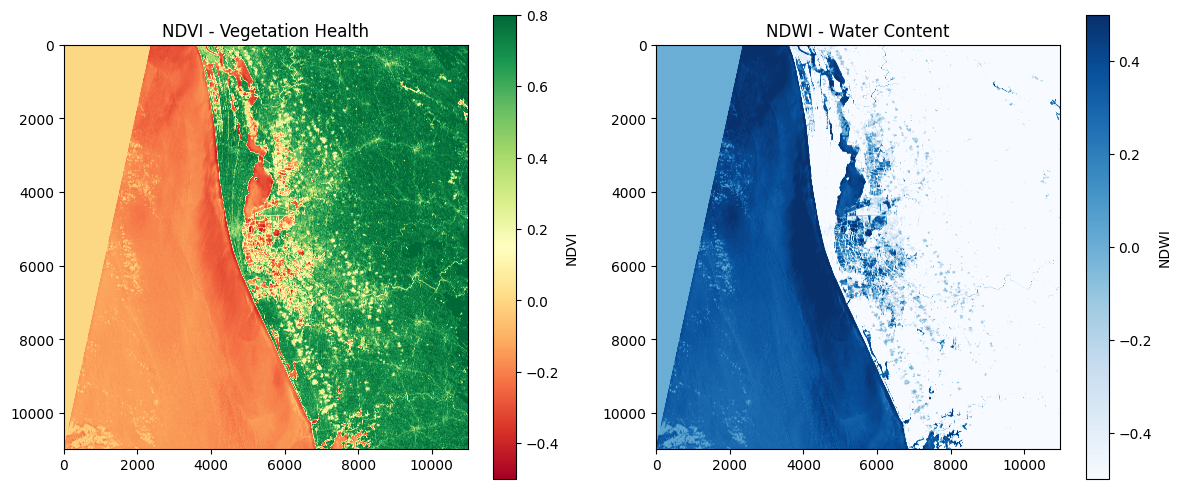

✅ NDVI mean: 0.265, NDWI mean: -0.163

📰 PHASE 2: Fetching Human Signals (GDELT)
  Found 437 Kerala events
  Found 877 Kerala events
  Found 1167 Kerala events
  Found 1562 Kerala events
  Found 1262 Kerala events
  Found 1568 Kerala events

✅ Total Kerala events: 6873
Average sentiment (AvgTone): -2.39
Sample URL: http://twocircles.net/2018aug14/425323.html

🕸️ PHASE 3: Building Multimodal Knowledge Graph
✅ Knowledge Graph: 6875 nodes, 3994 edges
✅ Interactive graph saved to artifacts/eco_kg.html

🗺️ PHASE 4: Creating Visualizations


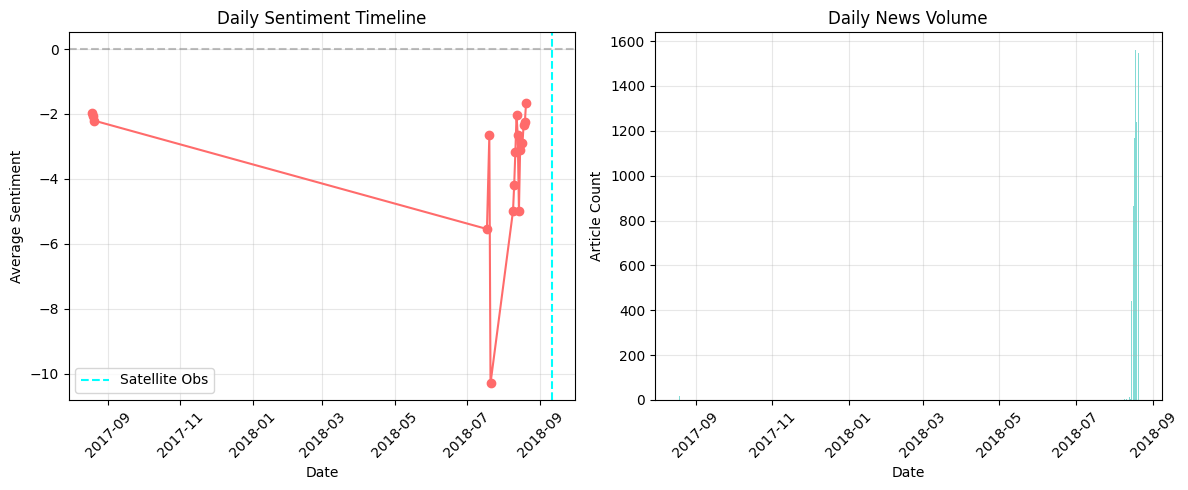

✅ Map and timeline created

📊 PHASE 5: Statistical Analysis
Pearson correlation (NDVI vs Sentiment): nan (p=nan)

Sentiment Statistics:
  Mean: -2.39
  Std: 2.54
  Min: -17.95
  Max: 7.28

🤖 PHASE 6: Agent Recommendations

🚨 PRIORITY: MEDIUM
📋 REASON: Vegetation stress with multiple negative reports
🎯 ACTIONS:
   - Monitor affected areas
   - Prepare relief resources

📊 EVIDENCE:
   mean_ndvi: 0.2647817245148008
   mean_ndwi: -0.16311209971036458
   mean_sentiment: -2.388308288621992
   negative_reports: 945
   total_reports: 6873
   observation_date: 2018-09-11T05:06:49.024000+00:00

🏆 ECOSPHERE X PIPELINE COMPLETE!

📁 Generated Artifacts:
   ✓ artifacts/ndvi.png - Satellite indices visualization
   ✓ artifacts/eco_map.html - Interactive map
   ✓ artifacts/eco_kg.html - Interactive knowledge graph
   ✓ artifacts/eco_kg.gexf - Graph for Gephi
   ✓ artifacts/timeline.png - Temporal analysis
   ✓ artifacts/agent_recommendation.json - AI decision output
   ✓ data/ndvi_summary.json - Satel

In [2]:
"""
EcoSphere X - Complete Hackathon Pipeline
Run this top-to-bottom in Kaggle to build your multimodal knowledge graph
"""

# ============================================================================
# PHASE 0: SETUP
# ============================================================================
print("🚀 PHASE 0: Environment Setup")

# Install dependencies
!pip install -q pystac-client planetary-computer rasterio geopandas shapely pyproj folium pyvis networkx matplotlib statsmodels scikit-learn

# Create folder structure
import os
os.makedirs('data/satellite', exist_ok=True)
os.makedirs('artifacts', exist_ok=True)

# Imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Point, box
import folium
from folium.plugins import MarkerCluster
import networkx as nx
from pyvis.network import Network
from pystac_client import Client
import planetary_computer
from datetime import datetime
import requests
from io import BytesIO
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

print("✅ Setup complete!\n")


# ============================================================================
# PHASE 1: SATELLITE DATA (Sentinel-2)
# ============================================================================
print("🛰️ PHASE 1: Fetching Satellite Data")

# Configuration
BBOX = [76.35, 9.8, 76.70, 10.1]  # Kerala flood region
DATE_RANGE = "2018-08-01/2018-09-05"
MAX_CLOUD_COVER = 30

# Connect to Planetary Computer
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

# Search for Sentinel-2
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=BBOX,
    datetime=DATE_RANGE,
    query={"eo:cloud_cover": {"lt": MAX_CLOUD_COVER}}
)

items = list(search.items())
print(f"Found {len(items)} Sentinel-2 scenes")

if len(items) == 0:
    print("⚠️ No items found. Expanding search...")
    DATE_RANGE = "2018-08-01/2018-09-30"
    search = catalog.search(collections=["sentinel-2-l2a"], bbox=BBOX, datetime=DATE_RANGE)
    items = list(search.items())

# Get the best item (least cloud cover)
item = min(items, key=lambda x: x.properties.get('eo:cloud_cover', 100))
print(f"Selected scene: {item.datetime} (Cloud: {item.properties.get('eo:cloud_cover', 'N/A')}%)")

# Download bands (B03=Green, B04=Red, B08=NIR)
def download_band(item, band_name, output_path):
    """Download a single band from Sentinel-2"""
    signed_asset = planetary_computer.sign(item.assets[band_name])
    with rasterio.open(signed_asset.href) as src:
        data = src.read(1)
        profile = src.profile
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)
    return data, profile

# Download bands
print("Downloading bands...")
b03, profile = download_band(item, 'B03', 'data/satellite/B03.tif')
b04, _ = download_band(item, 'B04', 'data/satellite/B04.tif')
b08, _ = download_band(item, 'B08', 'data/satellite/B08.tif')

# Compute indices
def compute_ndvi(nir, red):
    """Normalized Difference Vegetation Index"""
    return (nir - red) / (nir + red + 1e-8)

def compute_ndwi(green, nir):
    """Normalized Difference Water Index"""
    return (green - nir) / (green + nir + 1e-8)

ndvi = compute_ndvi(b08.astype(float), b04.astype(float))
ndwi = compute_ndwi(b03.astype(float), b08.astype(float))

# Save summary
ndvi_summary = {
    "mean_ndvi": float(np.nanmean(ndvi)),
    "mean_ndwi": float(np.nanmean(ndwi)),
    "std_ndvi": float(np.nanstd(ndvi)),
    "std_ndwi": float(np.nanstd(ndwi)),
    "bounds": BBOX,
    "crs": profile['crs'].to_string(),
    "observation_date": item.datetime.isoformat()
}

with open('data/ndvi_summary.json', 'w') as f:
    json.dump(ndvi_summary, f, indent=2)

# Visualize NDVI
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-0.5, vmax=0.8)
plt.colorbar(label='NDVI')
plt.title('NDVI - Vegetation Health')
plt.subplot(1, 2, 2)
plt.imshow(ndwi, cmap='Blues', vmin=-0.5, vmax=0.5)
plt.colorbar(label='NDWI')
plt.title('NDWI - Water Content')
plt.tight_layout()
plt.savefig('artifacts/ndvi.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ NDVI mean: {ndvi_summary['mean_ndvi']:.3f}, NDWI mean: {ndvi_summary['mean_ndwi']:.3f}\n")


# ============================================================================
# PHASE 2: HUMAN SIGNALS (GDELT)
# ============================================================================
print("📰 PHASE 2: Fetching Human Signals (GDELT)")

# GDELT column names
GDELT_COLUMNS = [
    "GLOBALEVENTID", "SQLDATE", "MonthYear", "Year", "FractionDate",
    "Actor1Code", "Actor1Name", "Actor1CountryCode", "Actor1KnownGroupCode",
    "Actor1EthnicCode", "Actor1Religion1Code", "Actor1Religion2Code",
    "Actor1Type1Code", "Actor1Type2Code", "Actor1Type3Code",
    "Actor2Code", "Actor2Name", "Actor2CountryCode", "Actor2KnownGroupCode",
    "Actor2EthnicCode", "Actor2Religion1Code", "Actor2Religion2Code",
    "Actor2Type1Code", "Actor2Type2Code", "Actor2Type3Code",
    "IsRootEvent", "EventCode", "EventBaseCode", "EventRootCode",
    "QuadClass", "GoldsteinScale", "NumMentions", "NumSources", "NumArticles",
    "AvgTone", "Actor1Geo_Type", "Actor1Geo_FullName", "Actor1Geo_CountryCode",
    "Actor1Geo_ADM1Code", "Actor1Geo_Lat", "Actor1Geo_Long", "Actor1Geo_FeatureID",
    "Actor2Geo_Type", "Actor2Geo_FullName", "Actor2Geo_CountryCode",
    "Actor2Geo_ADM1Code", "Actor2Geo_Lat", "Actor2Geo_Long", "Actor2Geo_FeatureID",
    "ActionGeo_Type", "ActionGeo_FullName", "ActionGeo_CountryCode",
    "ActionGeo_ADM1Code", "ActionGeo_Lat", "ActionGeo_Long", "ActionGeo_FeatureID",
    "DATEADDED", "SOURCEURL"
]

# Download GDELT data for the flood period
gdelt_dates = ["20180815", "20180816", "20180817", "20180818", "20180819", "20180820"]
all_events = []

for date in gdelt_dates:
    try:
        url = f"http://data.gdeltproject.org/events/{date}.export.CSV.zip"
        print(f"Downloading GDELT {date}...")
        df = pd.read_csv(url, sep='\t', names=GDELT_COLUMNS, compression='zip', low_memory=False)
        
        # Filter for Kerala
        kerala = df[
            (df["ActionGeo_FullName"].str.contains("Kerala", case=False, na=False)) |
            ((df["ActionGeo_Lat"] >= BBOX[1]) & (df["ActionGeo_Lat"] <= BBOX[3]) &
             (df["ActionGeo_Long"] >= BBOX[0]) & (df["ActionGeo_Long"] <= BBOX[2]))
        ]
        all_events.append(kerala)
        print(f"  Found {len(kerala)} Kerala events")
    except Exception as e:
        print(f"  ⚠️ Failed to download {date}: {e}")

# Combine all events
human_signals = pd.concat(all_events, ignore_index=True)
print(f"\n✅ Total Kerala events: {len(human_signals)}")

# Clean and save
human_signals = human_signals[[
    "GLOBALEVENTID", "SQLDATE", "AvgTone", "NumArticles",
    "ActionGeo_Lat", "ActionGeo_Long", "ActionGeo_FullName", "SOURCEURL"
]].dropna(subset=["ActionGeo_Lat", "ActionGeo_Long", "AvgTone"])

human_signals.to_csv('data/human_signals.csv', index=False)

# Convert to JSON
human_clean = []
for idx, row in human_signals.iterrows():
    human_clean.append({
        "id": f"news_{int(row['GLOBALEVENTID'])}",
        "timestamp": str(row['SQLDATE']),
        "sentiment": float(row['AvgTone']),
        "lat": float(row['ActionGeo_Lat']),
        "lon": float(row['ActionGeo_Long']),
        "location": row['ActionGeo_FullName'],
        "url": row['SOURCEURL'] if pd.notna(row['SOURCEURL']) else ""
    })

with open('data/human_clean.json', 'w') as f:
    json.dump(human_clean, f, indent=2)

print(f"Average sentiment (AvgTone): {human_signals['AvgTone'].mean():.2f}")
print(f"Sample URL: {human_clean[0]['url']}\n")


# ============================================================================
# PHASE 3: BUILD KNOWLEDGE GRAPH
# ============================================================================
print("🕸️ PHASE 3: Building Multimodal Knowledge Graph")

G = nx.Graph()

# Add Place node
G.add_node("kerala_region", 
           type="Place",
           mean_ndvi=ndvi_summary['mean_ndvi'],
           mean_ndwi=ndvi_summary['mean_ndwi'],
           bounds=str(BBOX))

# Add Observation node
G.add_node("sentinel_obs_1",
           type="Observation",
           timestamp=ndvi_summary['observation_date'],
           source="Sentinel-2",
           ndvi=ndvi_summary['mean_ndvi'],
           ndwi=ndvi_summary['mean_ndwi'])

G.add_edge("sentinel_obs_1", "kerala_region", relation="OBSERVED_AT")

# Add HumanSignal nodes
region_poly = box(*BBOX)
for signal in human_clean:
    node_id = signal['id']
    G.add_node(node_id,
               type="HumanSignal",
               timestamp=signal['timestamp'],
               sentiment=signal['sentiment'],
               lat=signal['lat'],
               lon=signal['lon'],
               url=signal['url'][:100])  # Truncate URL
    
    # Link to place if within bounds
    point = Point(signal['lon'], signal['lat'])
    if region_poly.contains(point):
        G.add_edge(node_id, "kerala_region", relation="REPORTS_ABOUT")

print(f"✅ Knowledge Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Save as GEXF
nx.write_gexf(G, 'artifacts/eco_kg.gexf')

# Create interactive visualization with PyVis
net = Network(height='600px', width='100%', bgcolor='#222222', font_color='white')
net.from_nx(G)

# Color nodes by type
color_map = {"Place": "#FF6B6B", "Observation": "#4ECDC4", "HumanSignal": "#95E1D3"}
for node in net.nodes:
    node_data = G.nodes[node['id']]
    node['color'] = color_map.get(node_data.get('type'), '#CCCCCC')
    node['title'] = f"{node_data.get('type', 'Unknown')}<br>" + "<br>".join([f"{k}: {v}" for k, v in list(node_data.items())[:5]])

net.save_graph('artifacts/eco_kg.html')
print("✅ Interactive graph saved to artifacts/eco_kg.html\n")


# ============================================================================
# PHASE 4: VISUALIZATIONS
# ============================================================================
print("🗺️ PHASE 4: Creating Visualizations")

# Folium map
center_lat = (BBOX[1] + BBOX[3]) / 2
center_lon = (BBOX[0] + BBOX[2]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles='CartoDB dark_matter')

# Add tile boundary
folium.Rectangle(
    bounds=[[BBOX[1], BBOX[0]], [BBOX[3], BBOX[2]]],
    color='cyan',
    fill=True,
    fillOpacity=0.1,
    popup='Sentinel-2 Tile'
).add_to(m)

# Add human signals with sentiment color
marker_cluster = MarkerCluster().add_to(m)
for signal in human_clean:
    sentiment = signal['sentiment']
    color = 'red' if sentiment < -5 else ('orange' if sentiment < 0 else 'green')
    folium.CircleMarker(
        location=[signal['lat'], signal['lon']],
        radius=5,
        popup=f"Sentiment: {sentiment:.1f}<br>{signal['location']}",
        color=color,
        fill=True,
        fillColor=color
    ).add_to(marker_cluster)

m.save('artifacts/eco_map.html')

# Timeline
human_signals['date'] = pd.to_datetime(human_signals['SQLDATE'], format='%Y%m%d')
timeline = human_signals.groupby('date').agg({
    'AvgTone': 'mean',
    'GLOBALEVENTID': 'count'
}).reset_index()
timeline.columns = ['date', 'avg_sentiment', 'article_count']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(timeline['date'], timeline['avg_sentiment'], marker='o', color='#FF6B6B')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=pd.to_datetime(item.datetime), color='cyan', linestyle='--', label='Satellite Obs')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Daily Sentiment Timeline')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(timeline['date'], timeline['article_count'], color='#4ECDC4', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Daily News Volume')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/timeline.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Map and timeline created\n")


# ============================================================================
# PHASE 5: ANALYTICS & CAUSALITY
# ============================================================================
print("📊 PHASE 5: Statistical Analysis")

# Aggregate sentiment by date
daily_sentiment = human_signals.groupby('date')['AvgTone'].mean().reset_index()
daily_sentiment['ndvi'] = ndvi_summary['mean_ndvi']  # Simplified - use constant NDVI

# Correlation
if len(daily_sentiment) > 2:
    corr, p_value = pearsonr(daily_sentiment['ndvi'], daily_sentiment['AvgTone'])
    print(f"Pearson correlation (NDVI vs Sentiment): {corr:.3f} (p={p_value:.3f})")
else:
    print("⚠️ Not enough data points for correlation analysis")

# Summary stats
print(f"\nSentiment Statistics:")
print(f"  Mean: {human_signals['AvgTone'].mean():.2f}")
print(f"  Std: {human_signals['AvgTone'].std():.2f}")
print(f"  Min: {human_signals['AvgTone'].min():.2f}")
print(f"  Max: {human_signals['AvgTone'].max():.2f}")


# ============================================================================
# PHASE 6: AGENT DECISION LAYER
# ============================================================================
print("\n🤖 PHASE 6: Agent Recommendations")

# Rule-based agent
mean_ndwi = ndvi_summary['mean_ndwi']
mean_ndvi = ndvi_summary['mean_ndvi']
mean_tone = human_signals['AvgTone'].mean()
neg_count = len(human_signals[human_signals['AvgTone'] < -5])
total_articles = len(human_signals)

# Decision logic
priority = "LOW"
reason = "Normal conditions"
actions = []

if mean_ndwi > 0.2 and mean_tone < -3:
    priority = "HIGH"
    reason = "High water content detected with negative sentiment"
    actions.append("Deploy emergency response teams")
    actions.append("Activate flood monitoring systems")
elif mean_ndvi < 0.3 and neg_count > 10:
    priority = "MEDIUM"
    reason = "Vegetation stress with multiple negative reports"
    actions.append("Monitor affected areas")
    actions.append("Prepare relief resources")
elif mean_tone < -2:
    priority = "MEDIUM"
    reason = "Overall negative sentiment detected"
    actions.append("Increase media monitoring")

recommendation = {
    "priority": priority,
    "reason": reason,
    "actions": actions,
    "evidence": {
        "mean_ndvi": float(mean_ndvi),
        "mean_ndwi": float(mean_ndwi),
        "mean_sentiment": float(mean_tone),
        "negative_reports": int(neg_count),
        "total_reports": int(total_articles),
        "observation_date": ndvi_summary['observation_date']
    },
    "confidence": "OBSERVATIONAL"
}

with open('artifacts/agent_recommendation.json', 'w') as f:
    json.dump(recommendation, f, indent=2)

print(f"\n🚨 PRIORITY: {priority}")
print(f"📋 REASON: {reason}")
print(f"🎯 ACTIONS:")
for action in actions:
    print(f"   - {action}")
print(f"\n📊 EVIDENCE:")
for key, val in recommendation['evidence'].items():
    print(f"   {key}: {val}")


# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("🏆 ECOSPHERE X PIPELINE COMPLETE!")
print("="*70)
print("\n📁 Generated Artifacts:")
print("   ✓ artifacts/ndvi.png - Satellite indices visualization")
print("   ✓ artifacts/eco_map.html - Interactive map")
print("   ✓ artifacts/eco_kg.html - Interactive knowledge graph")
print("   ✓ artifacts/eco_kg.gexf - Graph for Gephi")
print("   ✓ artifacts/timeline.png - Temporal analysis")
print("   ✓ artifacts/agent_recommendation.json - AI decision output")
print("   ✓ data/ndvi_summary.json - Satellite metrics")
print("   ✓ data/human_clean.json - Processed news data")
print("\n🎯 Demo Tips:")
print("   1. Show the NDVI visualization (vegetation health)")
print("   2. Open eco_map.html (interactive clusters)")
print("   3. Display eco_kg.html (multimodal connections)")
print("   4. Explain the agent recommendation with evidence")
print("   5. Emphasize: Satellite + Human signals = Better decisions")
print("\n🚀 GOOD LUCK WITH YOUR HACKATHON! 🚀\n")